## Setup

In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

if not os.path.isdir('src'):
    !git init .
    !git remote add origin https://github.com/Manuel-Materazzo/Blood-Glucose-Prediction.git

!git pull origin master
        
from src.trainers.accurate_cross_trainer import AccurateCrossTrainer
from src.trainers.cached_accurate_cross_trainer import CachedAccurateCrossTrainer
from src.hyperparameter_optimizers.optuna_optimizer import OptunaOptimizer
from src.hyperparameter_optimizers.balanced_grid_optimizer import BalancedGridOptimizer

pd.set_option('display.max_columns', None)

def multiply_data(df):
    """
    Reduce data from the previous 6 hours of each row to 3 hours.
    Use the remaining 3 hours to create another row, effectively doubling the data.
    :param df:
    :return:
    """
    rows = []
    # for each row in the dataset
    for idx, row in df.iterrows():
        row_dict = row.to_dict()

        # row_dict is one row of the original dataset, we need to extract 2 rows out of it.

        # Create first 3 hours row by removing 3-6 columns (keep from 0:00 to 2:55)
        row1 = {k: v for k, v in row_dict.items() if k.split('-')[-1].startswith(('0', '1', '2')) or ':' not in k}
        # Prediction target is the same
        row1['bg+1:00'] = row_dict['bg+1:00']
        rows.append(row1)

        # The prediction target for row will be bg-2:00 (1 hour in the future for bg-3:00)
        # But sometimes is NaN, we'll get the first non NaN value
        row2_target = 0
        for col in ['bg-2:00', 'bg-2:05', 'bg-2:10', 'bg-2:15', 'bg-2:20']:
            if pd.notna(row_dict.get(col)):
                row2_target = row_dict[col]

        # Create last 3 hours row by removing 0-2 columns (keep from 3:00 to 5:55).
        row2 = {k: v for k, v in row_dict.items() if k.split('-')[-1].startswith(('3', '4', '5')) or ':' not in k}
        # Set the prediction target
        row2['bg+1:00'] = row2_target
        # Set the 'time' column to be the time of bg-3:00 collection (3 hours before the current 'time' value)
        hours_ago = pd.to_datetime(row2['time'], format='%H:%M:%S') - pd.Timedelta(hours=3)
        row2['time'] = hours_ago.strftime(r'%H:%M:%S')

        # Adjust column names for the second row to reflect the correct time intervals (shift 3 hours)
        corrected_row2 = {k.replace('3:', '0:').replace('4:', '1:').replace('5:', '2:'): v for k, v in row2.items()}

        rows.append(corrected_row2)

    return pd.DataFrame(rows).sort_values(by=['p_num', 'time']).reset_index(drop=True)

def load_data():
    # Load the data
    file_path = '/kaggle/input/brist1d/train.csv'
    data = pd.read_csv(file_path, index_col='id')

    # Don't rescale data, it does seem to worsen LB score
    #data = multiply_data(data)
    
    # Remove rows with missing target, separate target from predictors
    data.dropna(axis=0, subset=['bg+1:00'], inplace=True)
    y = data['bg+1:00']
    data.drop(['bg+1:00'], axis=1, inplace=True)
    #data.drop(['p_num'], axis=1, inplace=True)
    return data, y

X, y = load_data()

From https://github.com/Manuel-Materazzo/Blood-Glucose-Prediction
 * branch            master     -> FETCH_HEAD
Already up to date.


/tmp/ipykernel_30/2417386683.py:65: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, index_col='id')


## Explore Data

In [2]:
X.head()

,p_num,time,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-2:55,cals-2:50,cals-2:45,cals-2:40,cals-2:35,cals-2:30,cals-2:25,cals-2:20,cals-2:15,cals-2:10,cals-2:05,cals-2:00,cals-1:55,cals-1:50,cals-1:45,cals-1:40,cals-1:35,cals-1:30,cals-1:25,cals-1:20,cals-1:15,cals-1:10,cals-1:05,cals-1:00,cals-0:55,cals-0:50,cals-0:45,cals-0:40,cals-0:35,cals-0:30,cals-0:25,cals-0:20,cals-0:15,cals-0:10,cals-0:05,cals-0:00,activity-2:55,activity-2:50,activity-2:45,activity-2:40,activity-2:35,activity-2:30,activity-2:25,activity-2:20,activity-2:15,activity-2:10,activity-2:05,activity-2:00,activity-1:55,activity-1:50,activity-1:45,activity-1:40,activity-1:35,activity-1:30,activity-1:25,activity-1:20,activity-1:15,activity-1:10,activity-1:05,activity-1:00,activity-0:55,activity-0:50,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
0,p01,00:00:00,NaN,4.9,NaN,NaN,4.2,NaN,NaN,4.2,NaN,NaN,4.7,NaN,NaN,4.2,NaN,NaN,3.9,NaN,NaN,5.5,NaN,NaN,7.2,NaN,NaN,7.8,NaN,NaN,NaN,8.4,NaN,NaN,8.3,NaN,NaN,7.3,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,0.0167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.5,93.6,99.8,90.6,99.3,106.2,114.9,106.4,114.7,99.2,74.6,72.8,70.8,73.7,70.9,74.7,76.2,74.8,75.8,81.4,69.7,72.5,65.0,63.4,67.0,70.3,71.8,68.4,66.0,61.8,64.4,70.1,70.6,74.2,73.6,78.1,61.0,277.0,64.0,128.0,138.0,365.0,546.0,601.0,533.0,72.0,0.0,0.0,27.0,0.0,0.0,23.0,24.0,59.0,22.0,99.0,4.0,0.0,7.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,8.0,8.0,76.0,16.0,33.0,27.0,15.40,20.60,20.79,13.18,10.30,9.34,13.76,14.15,20.99,18.97,14.45,5.60,10.79,19.83,14.06,13.48,19.44,24.46,30.43,30.43,29.46,13.48,5.20,5.20,8.19,5.39,5.10,8.19,8.08,11.07,8.19,13.67,6.45,5.20,6.35,6.26,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,Walk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p01,00:00:00,NaN,4.9,NaN,N

#### Initial observations
* The dataset is composed of some metrics collected by a smartwarch.
* Aside from identification fields, columns are named after a metric-timedelta convention, where time delta is a hour:minute value of time.
* Data is collected every 10 to 20 minutes.
* For each metric, there is a time delta column every 5 minutes for 6 hours.
* It seems that only 1 out of 3 delta columns is valorized. This alignes with the supposed 15 minutes data collection policy. **This means that probably patients collect data asynchronously and we'll have to do backward and forward filling**.

In [4]:
# individual mesurement types
column_types = []
for column in X.columns:
    column_type = column.split("-")[0]
    column_types.append(column_type)

deduplicated_column_types = list(dict.fromkeys(column_types))
print(deduplicated_column_types)

['p_num', 'time', 'bg', 'insulin', 'carbs', 'hr', 'steps', 'cals', 'activity']


In [5]:
# all patients with data count
X.p_num.value_counts()

p_num
p03    26028
p02    25872
p10    25454
p12    25299
p04    24686
p11    24555
p01     8459
p06     8383
p05     8288
Name: count, dtype: int64

The dataset enumerates patients from p1 to p12, p-07 to p-09 are missing. We have 9 of the 24 patients data in the training set.

Some patients have less data, did they wear smartwatches for a different amount of time?

/tmp/ipykernel_30/162444087.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['hour'] = pd.to_datetime(X.time).dt.hour


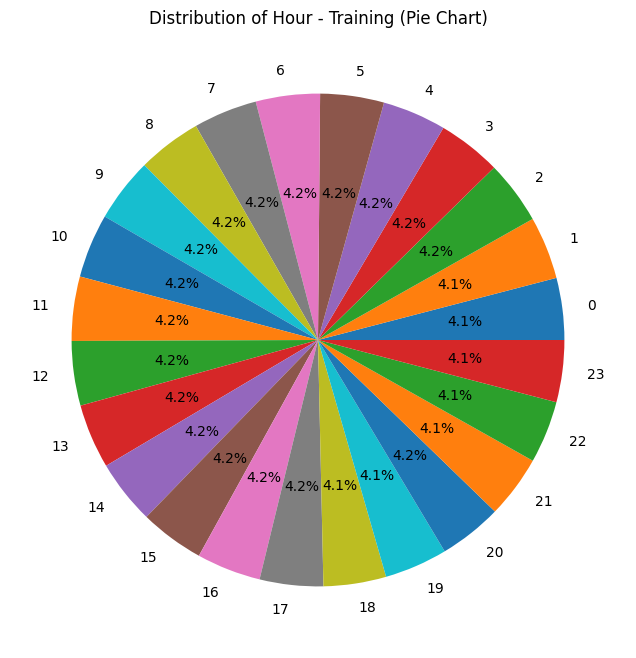

In [6]:
# survey times for each patient
X.groupby(['p_num']).time.nunique()

X['hour'] = pd.to_datetime(X.time).dt.hour
plt.figure(figsize=(8, 8))
X['hour'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Hour - Training (Pie Chart)')
plt.ylabel('')
plt.show()

Patients have the same amount of surveys, one every 5 minutes for the whole 24 hours. The difference in data amounts to the wearing time in days.

/tmp/ipykernel_30/1213112117.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['hour'] = pd.to_datetime(X.time).dt.hour


<Axes: xlabel='p_num', ylabel='diff'>

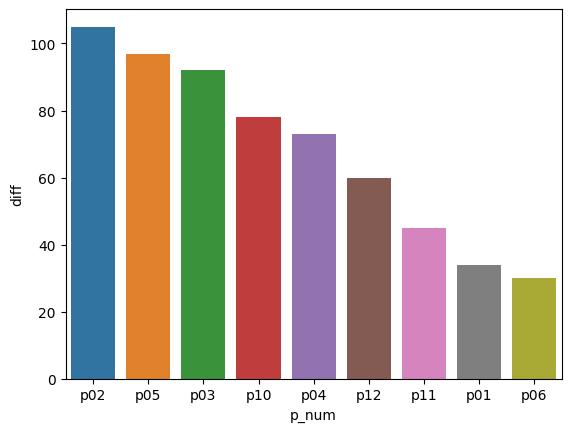

In [7]:
# Difference from the most and the least measured hours between patients (hour survey delta)

# cast the time column to datetime and extract the hour on a "hour" column
X['hour'] = pd.to_datetime(X.time).dt.hour

# group by patient and hour, to get all time counts
time_counts = X.groupby(['p_num', 'hour']).p_num.count()

# get maximum and minimum number of surveys (hour) of each patient
patient_minmax = time_counts.groupby(['p_num']).aggregate(['max', 'min'])

# calculate diff
patient_minmax['diff'] = patient_minmax['max'] - patient_minmax['min']

# sort
patient_minmax = patient_minmax.sort_values(by='diff', ascending=False)

sns.barplot(y=patient_minmax['diff'], x=patient_minmax.index)

Patients with more data have increased missing surveys.

Why patient 5 has high delta with low data numerosity?

/tmp/ipykernel_30/4289415655.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_counts_df['hour'] = pd.to_datetime(time_counts_df.index).hour


<Axes: xlabel='hour', ylabel='count'>

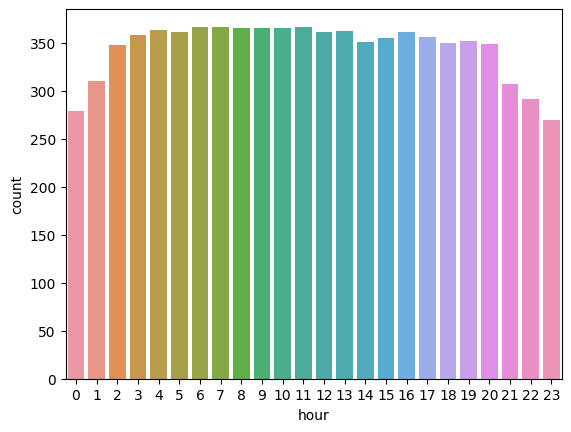

In [8]:
# Hour distribution of patient 5 surveys (has high hour survey delta, but low datapoint numerosity)

# filter by patient 1
p05_X = X.loc[X.p_num == 'p05']
# get all time counts
time_counts = p05_X.time.value_counts()

time_counts_df = pd.DataFrame(time_counts)

# cast the time column to datetime and extract the hour on a "hour" column
time_counts_df['hour'] = pd.to_datetime(time_counts_df.index).hour

# group by hour
time_counts_df_grouped = time_counts_df.groupby('hour').sum()

# sort
time_counts_df_grouped = time_counts_df_grouped.sort_values(by='count', ascending=False)

sns.barplot(y=time_counts_df_grouped['count'], x=time_counts_df_grouped.index )

There is, more or less, the same amount of data for each hour. Patient 5 probably wore the smartwatch wrong on some nights.

In [9]:
# check if patients have consistent missing columns
patients = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12']
for patient_id in patients:
    patient_X = X.loc[X.p_num == patient_id]
    cols_with_missing = len([col for col in X.columns if X[col].isnull().any()])
    print("{} columns with missing data: {}".format(patient_id, cols_with_missing))


p01 columns with missing data: 504
p02 columns with missing data: 504
p03 columns with missing data: 504
p04 columns with missing data: 504
p05 columns with missing data: 504
p06 columns with missing data: 504
p10 columns with missing data: 504
p11 columns with missing data: 504
p12 columns with missing data: 504


Provided that we have data points every 5 minutes, and on each column there are missing data, we can conclude that data collection times are not consistent on the same patient.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

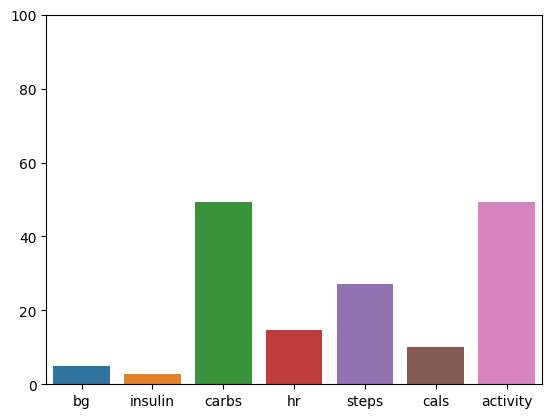

In [17]:
# count duplicated rows
print(f"There are {sum(X.duplicated())} duplicated rows in the train data frame.")

# count rows
row_count = X.shape[0]

# get a serie with missing value columns and count
features_with_missing_values = [col for col in X.columns if X[col].isnull().any()]
missing_values_counts = X[features_with_missing_values].isnull().sum()

# group by metric
missing_counts_grouped_by_metrics = {}
for key, value in missing_values_counts.items():
     metric = key.split("-")[0]
     missing_counts_grouped_by_metrics[metric] = (missing_counts_grouped_by_metrics.get(metric) or 0) + value

# convert to key-value list
keys = list(missing_counts_grouped_by_metrics.keys())
vals = list(missing_counts_grouped_by_metrics.values())

# convert values in percentage
vals = [(i * 100 / (row_count * 72)) for i in vals]

# set the plot max to 100, for accurate percentage representations
plt.ylim(0, 100)
sns.barplot(x=keys, y=vals)

/tmp/ipykernel_30/3109377547.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
/tmp/ipykernel_30/3109377547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
/tmp/ipykernel_30/3109377547.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hour', y='count', hue='p_num', data=grouped, ci=None)


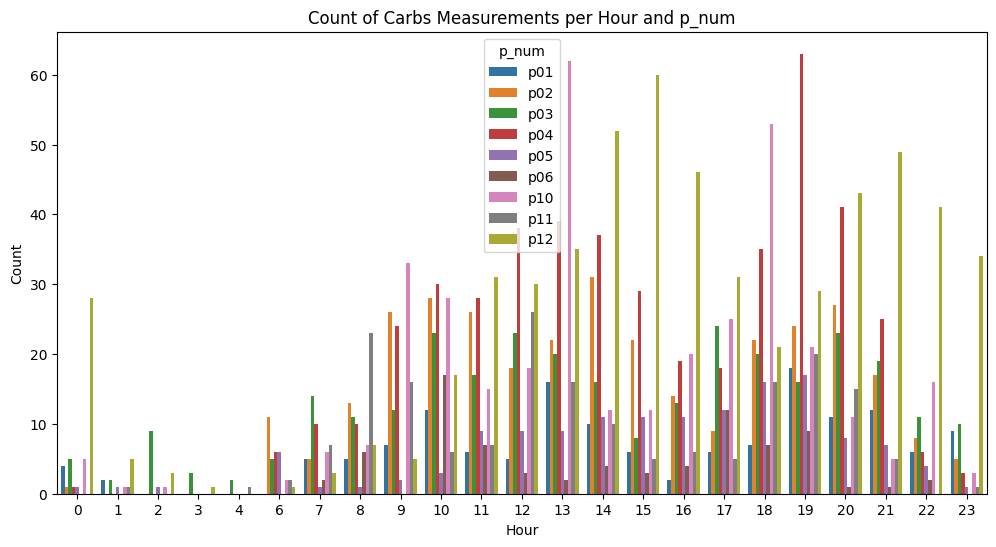

In [10]:
# check for time patterns on carbs surveys
carbs_X = X.loc[X['carbs-0:00'].notnull()]
carbs_X['hour'] = pd.to_datetime(carbs_X['time'].values).hour
carbs_X = carbs_X[['p_num','carbs-0:00', 'hour']]

grouped = carbs_X.groupby(['p_num', 'hour']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', hue='p_num', data=grouped, ci=None)

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Carbs Measurements per Hour and p_num')
plt.legend(title='p_num')
plt.show()

carbs and activity have a great deal of empty data, but the distribution of the data we have is on the whole day.

/tmp/ipykernel_30/2437430385.py:3: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  whole_data = pd.read_csv(file_path, index_col='id')


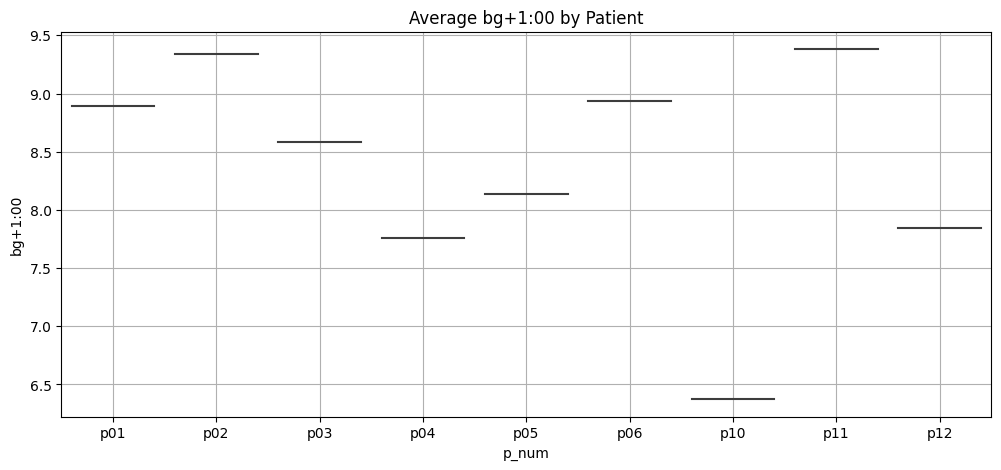

In [14]:
# Aggregate data by patient and plot the distribution
file_path = '/kaggle/input/brist1d/train.csv'
whole_data = pd.read_csv(file_path, index_col='id')

df_patient_avg = whole_data.groupby('p_num')['bg+1:00'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.violinplot(data=df_patient_avg, x='p_num', y='bg+1:00')
plt.title('Average bg+1:00 by Patient')
plt.grid(True)
plt.show()

## Define a pipeline

In [ ]:
from pandas import DataFrame
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from src.pipelines.dt_pipeline import DTPipeline

# Create a dictionary that maps each unique activity to a number, activities are sorted by their physical strain
activity_dictionary = {'None': 0, 'Yoga': 1, 'Walking': 2, 'Walk': 2, 'Dancing': 3, 'Zumba': 4, 'Strength training': 5,
                       'Weights': 6, 'Aerobic Workout': 7, 'Workout': 8, 'HIIT': 9, 'Run': 10, 'Running': 10,
                       'Bike': 11, 'Outdoor Bike': 11, 'Stairclimber': 12, 'Spinning': 13, 'Swim': 14, 'Swimming': 14,
                       'Tennis': 15, 'Indoor climbing': 16, 'Hike': 17, 'Sport': 18}

partecipants_dictionary = {'p01': 1, 'p02': 2, 'p03': 3, 'p04': 4, 'p05': 5, 'p06': 6, 'p07': 7, 'p08': 8, 'p09': 9,
                           'p10': 10, 'p11': 11, 'p12': 12, 'p13': 13, 'p14': 14, 'p15': 15, 'p16': 16, 'p17': 17,
                           'p18': 18, 'p19': 19, 'p20': 20, 'p21': 21, 'p22': 22, 'p23': 23, 'p24': 24}


class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        steps_columns = []
        activity_columns = []
        carbs_columns = []
        cals_columns = []

        for column in X.columns:
            # if the column is a metric with a survey time
            if 'steps-' in column:
                steps_columns.append(column)
            if 'activity-' in column:
                activity_columns.append(column)
            if 'carbs-' in column:
                carbs_columns.append(column)
            if 'cals-' in column:
                cals_columns.append(column)

        X[activity_columns] = X[activity_columns].fillna('None')  # assume no activity when empty

        # apply static encoding for activities
        for col in activity_columns:
            # Assign values based on the dictionary and set -1 for empty values
            X[col] = X[col].apply(lambda x: activity_dictionary.get(x, -1) if x != '' else -1)

        # apply static encoding for patients
        # Assign values based on the dictionary and set -1 for empty values
        # X['p_num'] = X['p_num'].apply(lambda x: partecipants_dictionary.get(x, -1) if x != '' else -1)

        X[steps_columns] = X[steps_columns].fillna(0)  # assume 0 steps when empty
        X[carbs_columns] = X[carbs_columns].fillna(0)  # assume 0 carbohydrate intake when empty
        X[cals_columns] = X[cals_columns].fillna(0)  # assume 0 calories burned when empty

        return X


class TimeTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a copy to avoid altering the original data
        X_copy = X.copy()

        # extract a hour and minute series
        time_col = pd.to_datetime(X_copy['time'], format='%H:%M:%S')
        hours = time_col.dt.hour
        minutes = time_col.dt.minute

        # create a hour sin and cos wave
        X_copy['hour_sin'] = np.sin(2 * np.pi * hours / 24)
        X_copy['hour_cos'] = np.cos(2 * np.pi * hours / 24)
        # create a minute sin and cos wave
        X_copy['minute_sin'] = np.sin(2 * np.pi * minutes / 60)
        X_copy['minute_cos'] = np.cos(2 * np.pi * minutes / 60)
        # remove time
        X_copy.drop(['time'], axis=1, inplace=True)

        return X_copy


class BackfillForwardFillTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a copy to avoid altering the original data
        X_copy = X.copy()

        # create a dictionary of metrics and their corresponding columns
        metric_columns = {}
        for column in X.columns:
            if '-' in column:
                # get the metric name
                metric_name = column.split("-")[0]
                # get the array of existing columns with the same metrics (or create it) and add the current column
                metric_columns_names = metric_columns.get(metric_name) or []
                metric_columns_names.append(column)
                # save the new array on the dictionary
                metric_columns[metric_name] = metric_columns_names

        # iterate metrics
        for key, value in metric_columns.items():
            # Sort the metric columns in descending order
            columns = sorted(value, key=lambda x: x.split('-')[1], reverse=True)

            # Fill missing values using backfill (and forward fill if the latest values are empty)
            X[columns] = X[columns].bfill()
            X[columns] = X[columns].ffill()

        return X_copy


class BrisT1DBloodGlucosePredictionDTPipeline(DTPipeline):
    def __init__(self, X: DataFrame, imputation_enabled: bool):
        super().__init__(X, imputation_enabled)

    def refresh_columns(self, X):
        """
        :param X:
        :return:
        """

        self.categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
        self.numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

        return X

    def create_preprocessor(self, X):
        # Encoding for categorical data
        categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

        # Preprocessing for numerical data
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ], memory=None)

        # Preprocessing for categorical data
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', categorical_encoder)
        ], memory=None)

        preprocessor = ColumnTransformer(transformers=[
            ('num', numerical_transformer, self.numerical_cols),
            ('cat', categorical_transformer, self.categorical_cols)
        ])

        return preprocessor.fit_transform(X)

    def build_pipeline(self) -> Pipeline | ColumnTransformer:
        # Bundle preprocessing
        return Pipeline(steps=[
            # sin cos time
            ('transform_time_columns', TimeTransformer()),
            # 0fill some columns and map to dictionaries
            ('custom_imputate_metric_columns', CustomImputer()),
            # refreshes column names
            ('refresh_columns', FunctionTransformer(self.refresh_columns, validate=False)),
            # backfill and forwardfill metric columns
            ('fill_metric_columns', BackfillForwardFillTransformer()),
            # impute remaining data
            ('preprocessor', FunctionTransformer(self.create_preprocessor, validate=False))
        ], memory=None)


### Train model

In [15]:
# reload data, just to be safe
X, y = load_data()

pipeline = BrisT1DBloodGlucosePredictionDTPipeline(X, True)

trainer = AccurateCrossTrainer(pipeline)

# optimizing parameters worsens performance for this dataset
optimized_params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.03,
            'n_jobs': -1,
}

# Train model
_, boost_rounds = trainer.validate_model(X, y, log_level=0, **optimized_params)

/tmp/ipykernel_30/393195696.py:60: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, index_col='id')


                 feats  importance
0         num__bg-0:00    0.142794
1         num__bg-0:15    0.011224
2           cat__p_num    0.009528
3         num__bg-0:05    0.009248
4   num__activity-5:40    0.007817
5         num__hr-0:00    0.007191
6   num__activity-0:05    0.006226
7         num__bg-0:30    0.006168
8   num__activity-4:35    0.005905
9   num__activity-3:15    0.004603
10       num__hour_cos    0.004482
11   num__insulin-0:35    0.004332
12   num__insulin-0:40    0.004217
13  num__activity-1:00    0.004165
14   num__insulin-0:25    0.004137
15  num__activity-3:35    0.004008
16        num__bg-0:10    0.003786
17       num__hour_sin    0.003764
18  num__activity-0:30    0.003726
19  num__activity-0:25    0.003701
20  num__activity-3:25    0.003534
21     num__steps-0:00    0.003466
22  num__activity-0:00    0.003407
23        num__bg-0:20    0.003391
24   num__insulin-0:30    0.003382
25  num__activity-5:30    0.003382
26  num__activity-5:55    0.003322
27   num__insulin-0:

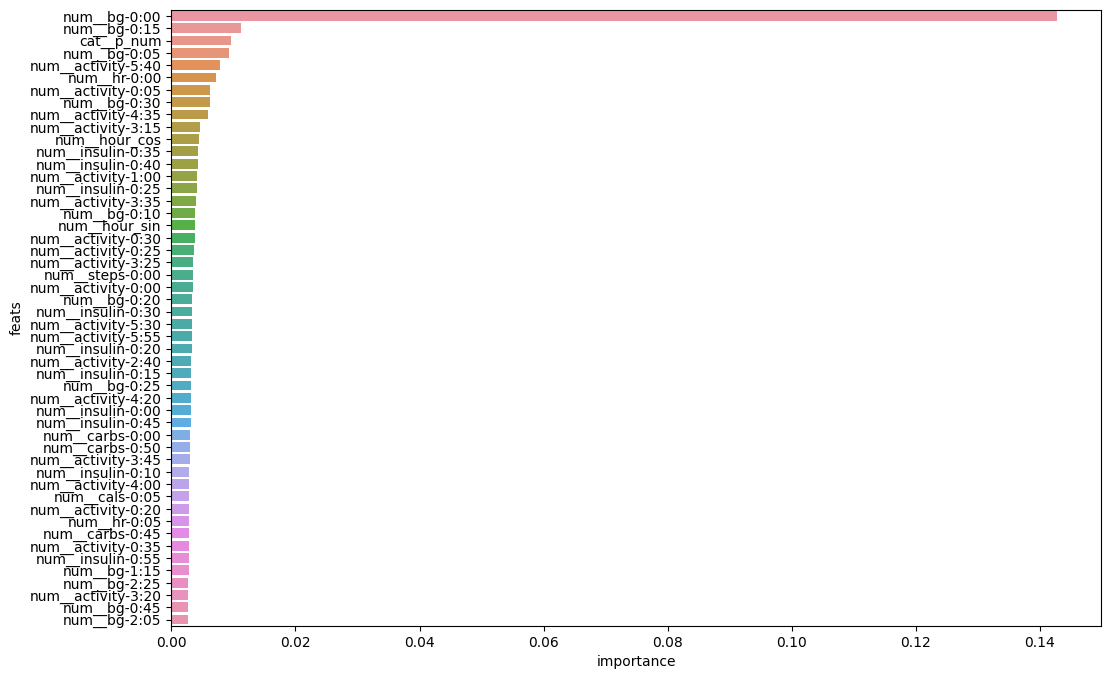

In [16]:
trainer.show_feature_importance(X)

## Train complete model on all data

In [ ]:
# fit complete_model on all data from the training data
complete_model = trainer.train_model(X, y, rounds=boost_rounds, **optimized_params)

## Make predictions on the competition data, and generate submission

In [ ]:
# Load the data
test_data_path = '/kaggle/input/brist1d/test.csv'
test_data = pd.read_csv(test_data_path, index_col='id')
#test_data.drop(['p_num'], axis=1, inplace=True)

processed_test_data = pipeline.transform(test_data)

# make predictions which we will submit. 
test_preds = complete_model.predict(processed_test_data)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_data.index,
                       'bg+1:00': test_preds})
output.to_csv('submission.csv', index=False)